## Predicting Crashes in Financial Markets - Linear Regression
- Datasets: S&P500 (USA), Nikkei225 (Japan), SSE (Shanghai/China), HSI (Hong Kong), BSESN (India), SMI (Switzerland), BVSP (Brazil)
- Model: Linear Regression
- Number of features: 504 (252 past days of price chages and volatility for each trading date)
- Response variable: Crash within 1 / 3 / 6 months (0: no, 1:yes)
- Crash definition: Drawdown in 99.5% quantile

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from datetime import datetime, timedelta
from pylab import rcParams
import os
import importlib
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
os.chdir('/home/roman/Documents/Projects/Bubbles/models')
from prepare_data_4b import DataLoader
from evaluate_results3 import EvaluateResults

In [118]:
# -------------------- Data preparation -------------------- #
os.chdir('/home/roman/Documents/Projects/Bubbles/data')
datasets_original = ['^GSPC.csv', '^N225.csv', 'SSE.csv','^HSI.csv', '^BSESN.csv',\
                     '^SSMI.csv', '^BVSP.csv']
dataset_names = ['S&P 500', 'N225', 'SSE', 'HSI', 'BSESN', 'SMI', 'BVSP']
data = DataLoader(datasets_original, dataset_names)

# specify drawdown thresholds for crashes (determined in exploration.ipynb):
crash_thresholds = [-0.0936, -0.1101, -0.1269, -0.1470, -0.1703, -0.1106, -0.2344]
df_combined, drawdowns, crashes = data.get_df_combined(crash_thresholds)
months = 3              # <-- predict if crash n months ahead (use: 1, 3 or 6)
sequence = None           # <-- number of days lookback as input(only if select_features=False)
dfs_xy = data.get_df_xy(months=months, sequence=sequence, df_combined=df_combined, crashes=crashes)

In [145]:
# -------------------- Train Linear Regression -------------------- #
model_name = 'Linear Regression'
test_data = 'S&P 500'
index_test = [i for i, name in enumerate(dataset_names) if name == test_data][0]
training_set_names = list(dataset_names)
training_set_names.pop(index_test)
y_train_all, y_test_all = [], []
y_pred_tr_all, y_pred_t_all = [], []
for val_data in training_set_names:
    np_train, np_test = data.get_train_test(dfs_xy, dataset_names, test_data=val_data)# change test->val in class
    x_train = np_train[:, 0:-1]
    y_train = np_train[:, -1].astype(int)
    y_train_all.append(y_train)
    x_test = np_test[:, 0:-1]
    y_test = np_test[:, -1].astype(int)
    y_test_all.append(y_test)
    print('Train ' + str(model_name) + ' - validation data: ' + str(val_data))
    lm = linear_model.LinearRegression()
    model = lm.fit(x_train, y_train)
    y_pred_tr = model.predict(x_train)
    y_pred_tr_all.append(y_pred_tr)
    y_pred_t = model.predict(x_test)
    y_pred_t_all.append(y_pred_t)

Train Linear Regression - validation data: N225
Train Linear Regression - validation data: SSE
Train Linear Regression - validation data: HSI
Train Linear Regression - validation data: BSESN
Train Linear Regression - validation data: SMI
Train Linear Regression - validation data: BVSP


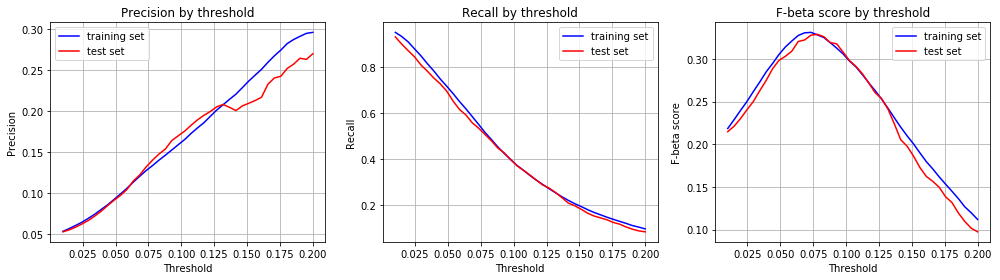

In [140]:
# -------------------- Find best threshold -------------------- #
beta = 2
rcParams['figure.figsize'] = 14, 4
eval_ = EvaluateResults(y_train_all, y_test_all, y_pred_tr_all, y_pred_t_all, model_name, test_data)
eval_.find_threshold(beta=beta, threshold_min=0.01, threshold_max=0.20, resolution=40)

In [141]:
# -------------------- Evaluate results -------------------- #
threshold = 0.07
beta = 2
print(model_name)
print('\n')
print('Predict crash in:               ' + str(months) + ' months')
print('Threshold for positives:        ' + str(threshold))
print('Number of features:             ' + str(dfs_xy[0].shape[1] - 1))
print('Number of rows in training set: ' + str(len(y_pred_tr_all[0]) + len(y_pred_t_all[0])))
print('\n')
eval_.training_results(threshold, training_set_names, beta=beta)

Linear Regression


Predict crash in:               3 months
Threshold for positives:        0.07
Number of features:             16
Number of rows in training set: 59738


Results for each train/val split:
                    N225   SSE   HSI  BSESN   SMI  BVSP
positive actual tr  0.04  0.04  0.04   0.04  0.04  0.04
positive pred tr    0.20  0.20  0.21   0.20  0.19  0.19
precision tr        0.13  0.12  0.12   0.12  0.12  0.12
recall tr           0.65  0.55  0.58   0.57  0.55  0.55
accuracy_tr         0.81  0.80  0.80   0.80  0.81  0.81
score_fbeta tr      0.37  0.32  0.33   0.33  0.32  0.32
positive actual t   0.05  0.04  0.04   0.04  0.05  0.04
positive pred t     0.26  0.18  0.21   0.20  0.18  0.14
precision t         0.07  0.15  0.10   0.11  0.14  0.19
recall t            0.38  0.74  0.53   0.53  0.48  0.64
accuracy_t          0.73  0.83  0.80   0.80  0.82  0.87
score fbeta t       0.20  0.41  0.29   0.30  0.33  0.44


Results - average over all train/val splits:
Positive train cas

In [142]:
# -------------------- Test model -------------------- #
np_train, np_test = data.get_train_test(dfs_xy, dataset_names, test_data=test_data)
x_train = np_train[:, 0:-1]
y_train = np_train[:, -1].astype(int)
x_test = np_test[:, 0:-1]
y_test = np_test[:, -1].astype(int)
lm = linear_model.LinearRegression()
model = lm.fit(x_train, y_train)
y_pred_t = model.predict(x_test)
y_pred_t_bin = eval_.test_results(y_test, y_pred_t, threshold, beta=beta)

Test results (test set: S&P 500):
Positive test cases actual:         0.04
Positive test cases predicted:      0.19
Precision test (model/random):      0.14 / 0.04
Recall test (model/random):         0.65 / 0.19
Accuracy test (model/random):       0.82 / 0.79
Score test fbeta:                   0.38 / 0.11


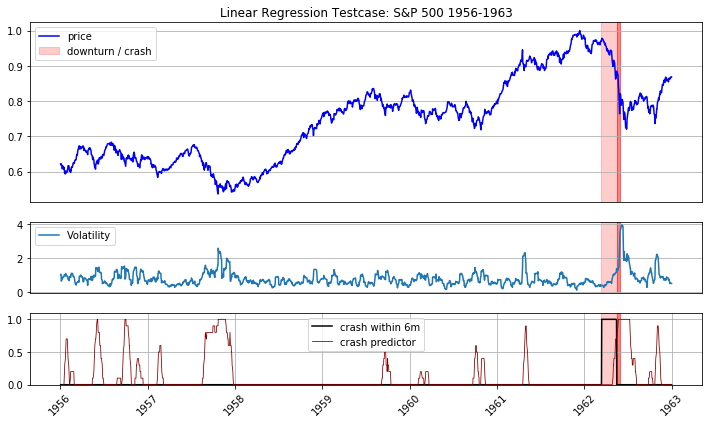

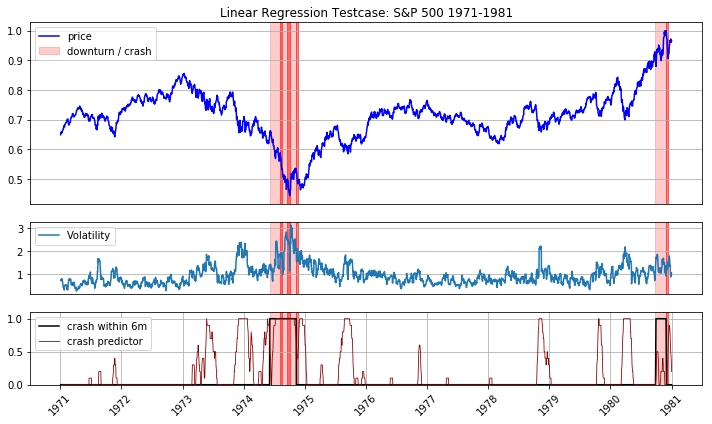

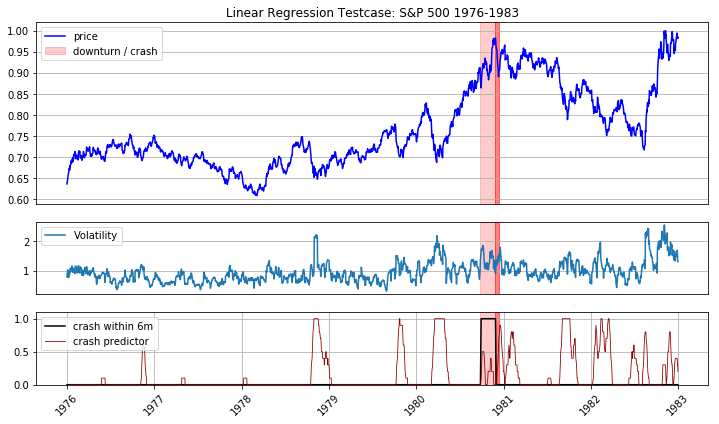

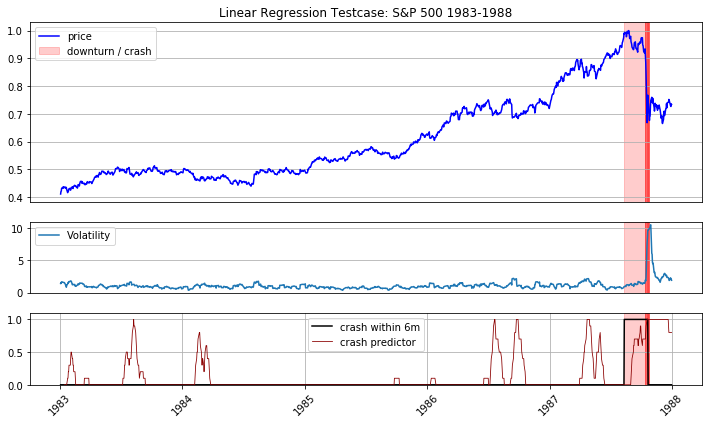

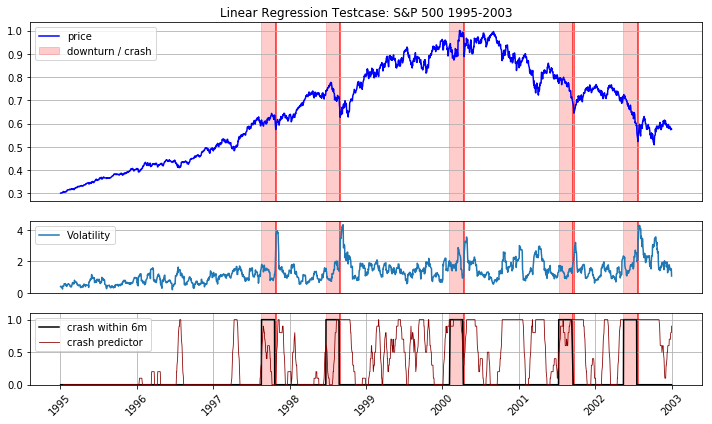

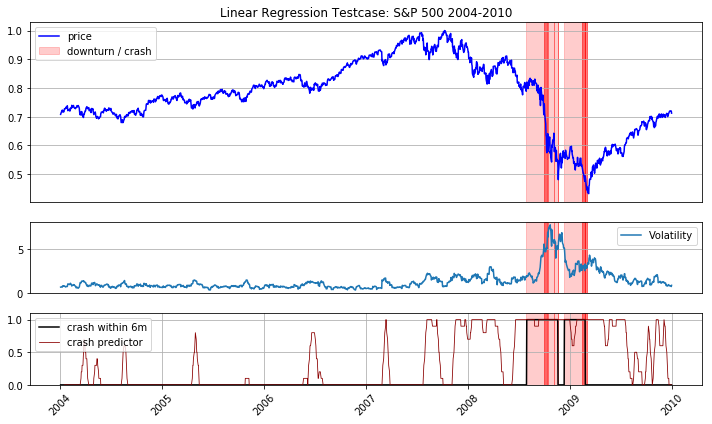

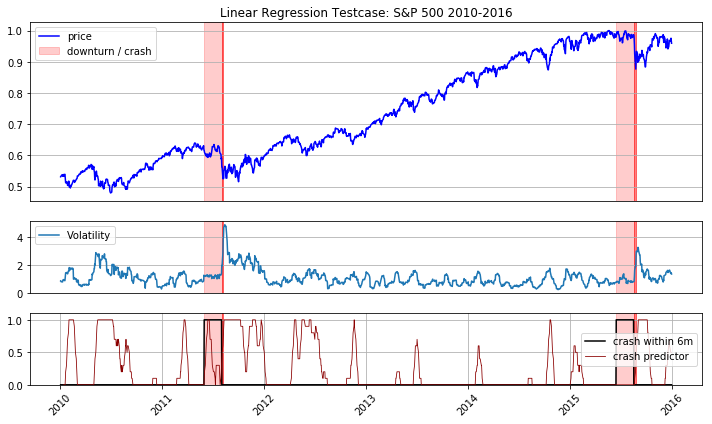

In [144]:
# -------------------- Plot test results -------------------- #
df = df_combined[index_test].reindex(dfs_xy[index_test].index)
df['y'] = y_test
df['y_pred'] = y_pred_t_bin
c = crashes[index_test]
t_start = ['1956-01-01', '1971-01-01', '1976-01-01', '1983-01-01', '1995-01-01', '2004-01-01', '2010-01-01']
t_end = ['1963-01-01', '1981-01-01', '1983-01-01', '1988-01-01', '2003-01-01', '2010-01-01', '2016-01-01']
rcParams['figure.figsize'] = 10, 6
eval_.plot_test_results(df, c, t_start, t_end)

In [ ]:
# -------------------- Current prediction S&P 500 -------------------- #
os.chdir('/home/roman/Documents/Projects/Bubbles/data')
datasets_original = ['^GSPC_new.csv', '^GSPC.csv']
dataset_names = ['S&P 500', 'S&P 500 old']
data = DataLoader(datasets_original, dataset_names)

# specify drawdown thresholds for crashes (determined in exploration.ipynb):
crash_thresholds = [-0.0936, -0.0936]
df_combined, drawdowns, crashes = data.get_df_combined(crash_thresholds)
months = 3              # <-- predict if crash n months ahead
sequence = None           # <-- number of days lookback as input(only if select_features=False)
dfs_xy_current = data.get_df_xy(months=months, sequence=sequence, df_combined=df_combined, crashes=crashes)